In [1]:
import os 
import sys 
import shutil
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
# set PYTHONPATH
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR) 
# import self-written modules
from src.preproc.input_gen import gen_input_inference
from src.ProtAIDeDx.main import args_parser as ProtAIDeDx_args_parser
from src.ProtAIDeDx.main import main as ProtAIDeDx_main
from src.utils.append_columns import append_columns
from src.utils.print_ProtAIDeDx_results import print_ProtAIDeDx_results_CV
from src.utils.metrics import clf_bas

In [3]:
# environment variables 
DATA_DIR = os.path.join(ROOT_DIR, 'data')
CKPT_DIR = os.path.join(ROOT_DIR, 'checkpoints')
DATA_CV_CKPT_DIR = os.path.join(CKPT_DIR, 'data_proc', 'CV')
MODEL_CKPT_DIR = os.path.join(CKPT_DIR, 'ProtAIDeDx')
EXAMPLE_DATA_DIR = os.path.join(ROOT_DIR, 'example', 'data')
EXAMPLE_RESULTS_DIR = os.path.join(ROOT_DIR, 'example', 'results')

hyper_params_path=os.path.join(ROOT_DIR, 
                               'checkpoints', 
                               'ProtAIDeDx', 'ProtAIDeDx_HyperParams.csv') 
probaThresholds_path=os.path.join(ROOT_DIR, 
                                 'checkpoints', 
                                 'ProtAIDeDx', 
                                 'ProtAIDeDx_ProbaThresholds.csv') 
data_path = os.path.join(DATA_DIR, 'Simulated_SomaLogic_120Subjects.csv')
targets = ['CU', 'AD', 'PD', 'FTD', 'ALS', 'StrokeTIA']
biomarkers = ['Age_at_Visit','MMSE', 'CSF_pTau217', 'TauPET_MetaROI', 
              'MRI_CTADSign', 'MRI_WMH']

In [4]:
# generating input for 10 folds of cross-validation
for fold in range(10):
    fold_ckpt_dir = os.path.join(DATA_CV_CKPT_DIR, f'fold_{fold}')
    fold_deep_input_dir = os.path.join(
        EXAMPLE_DATA_DIR, f'fold_{fold}', 'deep_input')
    fold_splits_dir = os.path.join(
        EXAMPLE_DATA_DIR, f'fold_{fold}', 'splits')
    os.makedirs(fold_deep_input_dir, exist_ok=True)
    os.makedirs(fold_splits_dir, exist_ok=True)

    # generate input for inference
    gen_input_inference(input_csv_path=data_path,
                        output_dir=fold_deep_input_dir,
                        ckpt_dir=fold_ckpt_dir,
                        categ_vars=targets,
                        conti_vars=[])
    # copy data to 'fold_{fold}/splits' dir
    shutil.copy2(data_path, os.path.join(fold_splits_dir, 'test.csv'))

In [5]:
# make predictions with pre-trained ProtAIDe-Dx models 
ProtAIDeDx_args = ProtAIDeDx_args_parser()
ProtAIDeDx_args.suffix = 'CV'
ProtAIDeDx_args.new = True 

# run inference for each fold
for fold in range(10):
    # set paths 
    fold_results_dir = os.path.join(
        EXAMPLE_RESULTS_DIR, 'ProtAIDeDx', f'fold_{fold}')
    os.makedirs(fold_results_dir, exist_ok=True)
    fold_input_dir = os.path.join(
        EXAMPLE_DATA_DIR, f'fold_{fold}', 'deep_input')
    fold_splits_dir = os.path.join(
        EXAMPLE_DATA_DIR, f'fold_{fold}', 'splits')
    # set args
    ProtAIDeDx_args.input_dir = fold_input_dir
    ProtAIDeDx_args.checkpoint_dir = MODEL_CKPT_DIR
    ProtAIDeDx_args.results_dir = fold_results_dir
    ProtAIDeDx_args.splits_dir = fold_splits_dir
    ProtAIDeDx_args.hyperParam_path = hyper_params_path
    ProtAIDeDx_args.probaThresholds_path = probaThresholds_path
    ProtAIDeDx_args.features_path = os.path.join(
        DATA_CV_CKPT_DIR, f'fold_{fold}', 'input_aptamers.txt')
    ProtAIDeDx_args.split  = 'fold_' + str(fold)
    # run ProtAIDe-Dx inference
    ProtAIDeDx_main(ProtAIDeDx_args)

# postprocessing 'fold_{fold}/test_results.csv' 
# by appending true labels & biomarker columns 
cols2append = targets + biomarkers
for fold in range(10):
    fold_results_dir = os.path.join(
        EXAMPLE_RESULTS_DIR, 'ProtAIDeDx', f'fold_{fold}')
    fold_splits_dir = os.path.join(
        EXAMPLE_DATA_DIR,  f'fold_{fold}', 'splits')
    # load data 
    pred_df = pd.read_csv(os.path.join(fold_results_dir, 'test_results.csv'))
    splits_df = pd.read_csv(os.path.join(fold_splits_dir, 'test.csv')) 
    merged_df = append_columns(pred_df,
                               splits_df,
                               cols_to_append=cols2append,
                               keys=['PersonGroup_ID'])
    # rename <target> columns as <target>-GT
    for target in targets:
        merged_df = merged_df.rename(columns={target: f'{target}-GT'})
    
    # reorder columns 
    target_full_cols  = []
    for t in targets:
        target_full_cols.append(f'{t}-GT')
        target_full_cols.append(f'{t}-PredLabel')
        target_full_cols.append(f'{t}-PredProb')
    z_cols = [col for col in merged_df.columns if 'Z' in col]
    ordered_cols = ['PersonGroup_ID', 'Visit', 'Contributor_Code'] \
        + target_full_cols + biomarkers + z_cols
    merged_df = merged_df[ordered_cols]
    # save data
    merged_df.to_csv(
        os.path.join(fold_results_dir, 'test_results_full.csv'), 
        index=False)

In [6]:
# print out summarized results across 10 folds 
# !!! Note that the results are on **simult
print_ProtAIDeDx_results_CV(
    results_dir=os.path.join(EXAMPLE_RESULTS_DIR, 'ProtAIDeDx'),
    sub_dirs_list=[f'fold_{fold}' for fold in range(10)]
)

   Target  AUC mean  AUC std  BCA mean  BCA std
  Control      0.97     0.01      0.82     0.04
       AD      0.95     0.02      0.88     0.04
       PD      0.96     0.04      0.80     0.08
      FTD      0.83     0.05      0.71     0.06
      ALS      1.00     0.00      0.97     0.02
StrokeTIA      0.69     0.05      0.63     0.05


In [7]:
# ensemble predictions across 10 folds
# i.e., if 5 out of 10 folds predict positive, 
# then the ensemble prediction is positive
# this might be useful when you seek optimal performances on your own dataset

def enumerate_predictions_CV(results_dir,
                             threshold,
                             nb_folds=10,
                             sub_col='PersonGroup_ID',
                             targets=targets):
    """
    Ensemble predictions across CV folds.

    Args:
        results_dir (_type_): _description_
        threshold (_type_): _description_
        nb_folds (int, optional): _description_. Defaults to 10.
        sub_col (str, optional): _description_. Defaults to 'PersonGroup_ID'.
        targets (_type_, optional): _description_. Defaults to targets.

    Returns:
        _type_: _description_
    """
    targets_gt_cols = [f'{t}-GT' for t in targets]
    fold0_pred_df = pd.read_csv(
        os.path.join(results_dir, 'fold_0', 'test_results_full.csv'))
    ensemble_pred_df = fold0_pred_df[
        [sub_col] + targets_gt_cols].copy().set_index(sub_col)
    
    for t in targets:
        ensemble_pred_df[f'{t}-PosCounts'] = 0
    
    for fold in range(nb_folds):
        fold_results_dir = os.path.join(results_dir, f'fold_{fold}')
        fold_pred_df = pd.read_csv(
            os.path.join(
                fold_results_dir, 'test_results.csv')).set_index(sub_col)
        for t in targets:
            ensemble_pred_df[f"{t}-PosCounts"] += fold_pred_df[
                f"{t}-PredLabel"].astype(int)
    for t in targets:
        ensemble_pred_df[f'{t}-Ensemble'] = (
            ensemble_pred_df[f'{t}-PosCounts'] >= threshold).astype(int)
    cols2keep = [sub_col]
    for t in targets:
        cols2keep.append(f'{t}-GT')
        cols2keep.append(f'{t}-PosCounts')
        cols2keep.append(f'{t}-Ensemble')
    
    ensemble_pred_df = ensemble_pred_df.reset_index()[cols2keep]

    return ensemble_pred_df

# ensemble predictions across 10 folds with threshold = 5
ensemble_pred_df = enumerate_predictions_CV(
    results_dir=os.path.join(EXAMPLE_RESULTS_DIR, 'ProtAIDeDx'),
    threshold=5,
    nb_folds=10,
    sub_col='PersonGroup_ID',
    targets=targets)

# get ensemble results
BCA_ensembles = {}
for t in targets:
    BCA = clf_bas(
        gt_vec=ensemble_pred_df[f'{t}-GT'].values.reshape(-1,),
        pred_vec=ensemble_pred_df[f'{t}-Ensemble'].values.reshape(-1,))
    BCA_ensembles[t] = BCA
    print(f'Ensemble results for {t}: BCA={BCA:.2f}')

Ensemble results for CU: BCA=0.81
Ensemble results for AD: BCA=0.95
Ensemble results for PD: BCA=0.90
Ensemble results for FTD: BCA=0.77
Ensemble results for ALS: BCA=0.95
Ensemble results for StrokeTIA: BCA=0.69


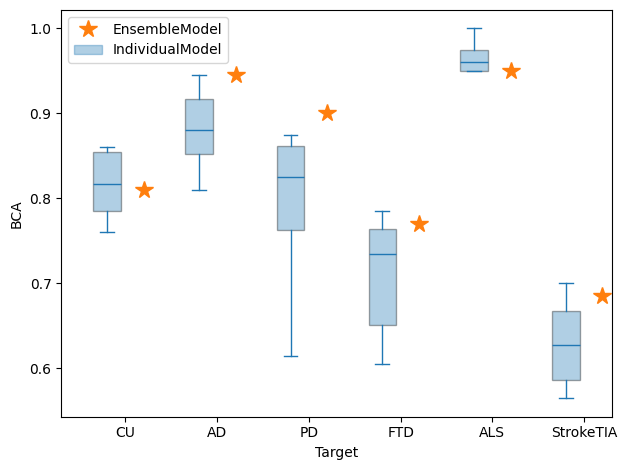

In [8]:
# visualization of prediction performances
# get performances per fold 
BCA_results = []
for fold in range(10):
    fold_results_dir = os.path.join(
        EXAMPLE_RESULTS_DIR, 'ProtAIDeDx', f'fold_{fold}')
    fold_metrics_df = pd.read_csv(
        os.path.join(fold_results_dir, 'test_metrics.csv'))
    fold_metrics_df['Hue'] = 'IndividualModel'
    for t in targets:
        BCA_results.append(
            [t, 
             fold_metrics_df.loc[fold_metrics_df['target'] == t, 'BCA'].values[0], 
             'IndividualModel'])
# results for ensemble 
for t in targets:
    BCA_results.append([t, BCA_ensembles[t], 'EnsembleModel'])    

BCA_results_df = pd.DataFrame(BCA_results, 
                              columns=['Target', 'BCA', 'Hue'])


def plot_bca_box_plus_star(df):
    targets = ['CU', 'AD', 'PD', 'FTD', 'ALS', 'StrokeTIA']
    x = np.arange(len(targets))
    jitter = 0.2  # separation between the two hues

    ind = df[df["Hue"] == "IndividualModel"]
    ens = df[df["Hue"] == "EnsembleModel"]

    # colors
    c_ind = "C0"
    c_ens = "C1"

    # boxplot (IndividualModel) shifted left
    box_data = [ind.loc[
        ind["Target"] == t, "BCA"].dropna().to_numpy() for t in targets]
    plt.boxplot(
        box_data,
        positions=x - jitter,
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=c_ind, alpha=0.35),
        medianprops=dict(color=c_ind),
        whiskerprops=dict(color=c_ind),
        capprops=dict(color=c_ind),
    )

    # stars (EnsembleModel) shifted right
    y_star = [ens.loc[ens["Target"] == t, "BCA"].iloc[0] for t in targets]
    plt.plot(
        x + jitter, y_star,
        linestyle="None",
        marker="*",
        markersize=13,
        color=c_ens,
    )

    # legend
    handles = [
        Line2D([0], [0], marker="*", linestyle="None", 
               color=c_ens, markersize=13, label="EnsembleModel"),
        Patch(facecolor=c_ind, edgecolor=c_ind, alpha=0.35, 
              label="IndividualModel"),
    ]
    plt.legend(handles=handles, loc="upper left")

    plt.xticks(x, targets)
    plt.xlabel("Target")
    plt.ylabel("BCA")
    plt.tight_layout()
    plt.show()

plot_bca_box_plus_star(BCA_results_df)

In [9]:
# visualization of individual probability distributions based on fitted tSNE
# TODO 

In [10]:
# SHapley Additive exPlanations (SHAP) analysis
# TODO 

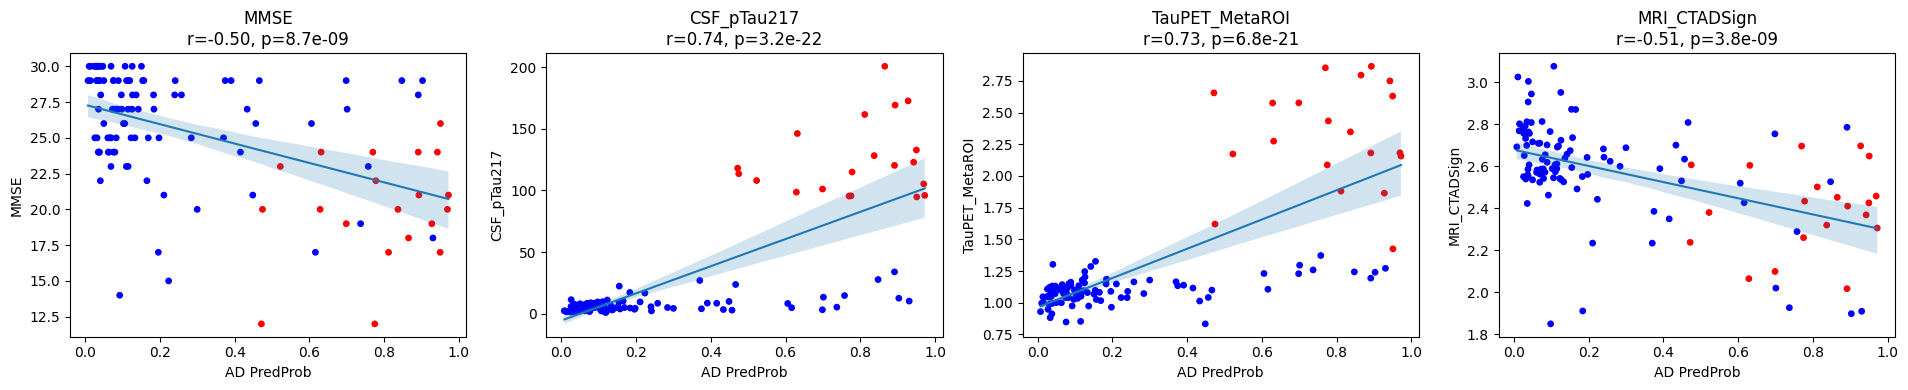

In [11]:
# Correlate biomarkers with predicted probabilities
# let's take model `fold_0`'s outputs as an example 
# check correlation between ADPredProb with AD biomarkers 
fold_pred_df = pd.read_csv(
    os.path.join(EXAMPLE_RESULTS_DIR, 'ProtAIDeDx', 
                 'fold_0', 'test_results_full.csv'))
AD_prob_col = 'AD-PredProb'
biomarkers_AD = ['MMSE', 'CSF_pTau217', 'TauPET_MetaROI', 'MRI_CTADSign']

def plot_adprob_vs_biomarkers(
    fold_pred_df,
    AD_prob_col="AD-PredProb",
    AD_gt_col="AD-GT",
    biomarkers_AD=("MMSE", "CSF_pTau217", "TauPET_MetaROI", "MRI_CTADSign"),
    n_boot=500,
    ci=95,
):
    fig, axes = plt.subplots(1, len(biomarkers_AD), figsize=(4.8 * len(biomarkers_AD), 4), sharex=True)
    axes = np.ravel(axes)

    x_all = pd.to_numeric(fold_pred_df[AD_prob_col], errors="coerce")
    gt_all = pd.to_numeric(fold_pred_df[AD_gt_col], errors="coerce")

    for ax, biom in zip(axes, biomarkers_AD):
        y_all = pd.to_numeric(fold_pred_df[biom], errors="coerce")
        d = pd.DataFrame({"x": x_all, "y": y_all, "gt": gt_all}).dropna()

        x = d["x"].to_numpy()
        y = d["y"].to_numpy()
        gt = d["gt"].astype(int).to_numpy()

        # color by AD-GT
        colors = np.where(gt == 1, "red", "blue")
        ax.scatter(x, y, s=15, c=colors)

        if len(d) >= 3:
            r, p = pearsonr(x, y)

            # OLS fit
            slope, intercept = np.polyfit(x, y, 1)
            xg = np.linspace(x.min(), x.max(), 200)
            yhat = intercept + slope * xg

            # bootstrap CI for mean prediction
            rng = np.random.default_rng(42)
            y_boot = np.empty((n_boot, xg.size), dtype=float)
            n = len(x)

            for b in range(n_boot):
                idx = rng.integers(0, n, size=n)
                xb = x[idx]
                yb = y[idx]
                sb, ib = np.polyfit(xb, yb, 1)
                y_boot[b] = ib + sb * xg

            alpha = (100 - ci) / 2
            lo = np.percentile(y_boot, alpha, axis=0)
            hi = np.percentile(y_boot, 100 - alpha, axis=0)

            ax.plot(xg, yhat)
            ax.fill_between(xg, lo, hi, alpha=0.2)

            ax.set_title(f"{biom}\nr={r:.2f}, p={p:.2g}")
        else:
            ax.set_title(f"{biom}\n(r=NA, p=NA)")

        ax.set_xlabel("AD PredProb")
        ax.set_ylabel(biom)

    plt.tight_layout()
    plt.show()

plot_adprob_vs_biomarkers(fold_pred_df, AD_prob_col, "AD-GT", biomarkers_AD)


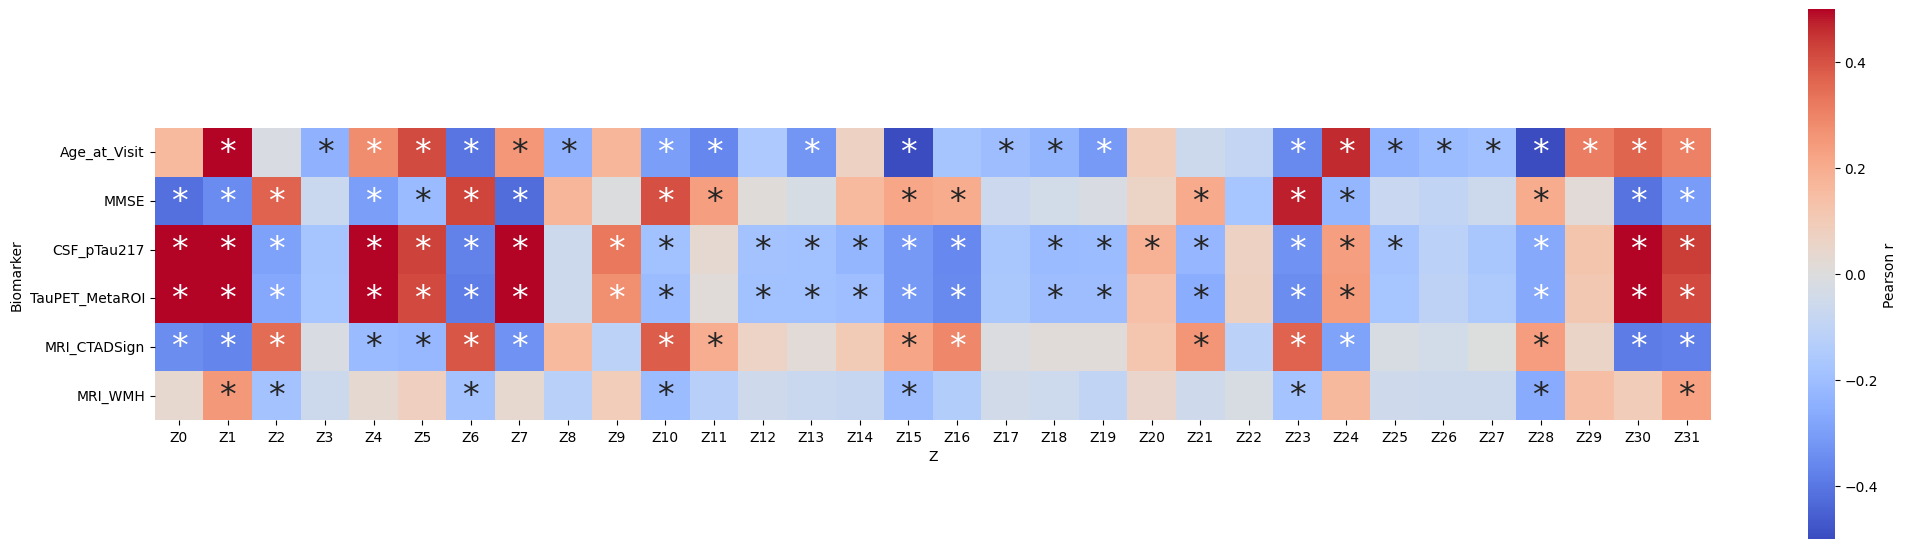

In [14]:
# Correlate biomarkers with model embeddings
# since the dimensionality last layer of model `fold_0` is 256
# let's take model `fold_0`'s first 32 embeddings as an example
z_cols = [f'Z{i}' for i in range(32)]

def corr_heatmap_with_stars(df, z_cols, biomarker_cols, p_thr=0.05):
    # r, p with rows=Biomarker (y), cols=Z (x)
    r = pd.DataFrame(index=biomarker_cols, columns=z_cols, dtype=float)
    p = pd.DataFrame(index=biomarker_cols, columns=z_cols, dtype=float)

    for b in biomarker_cols:
        y = pd.to_numeric(df[b], errors="coerce")
        for z in z_cols:
            x = pd.to_numeric(df[z], errors="coerce")
            d = pd.DataFrame({"x": x, "y": y}).dropna()
            if len(d) >= 3:
                rr, pp = pearsonr(d["x"].to_numpy(), d["y"].to_numpy())
                r.loc[b, z] = rr
                p.loc[b, z] = pp
            else:
                r.loc[b, z] = np.nan
                p.loc[b, z] = np.nan

    ann = p.applymap(lambda v: "*" if pd.notna(v) and v < p_thr else "")

    plt.figure(figsize=(0.6 * len(z_cols) + 2, 0.6 * len(biomarker_cols) + 2))
    ax = sns.heatmap(
        r,
        cmap="coolwarm",
        vmin=-0.5, 
        vmax=0.5,
        square=True,
        annot=ann, 
        annot_kws={"size": 24},
        fmt="",
        cbar_kws={"label": "Pearson r"},
    )
    ax.set_xlabel("Z")
    ax.set_ylabel("Biomarker")
    plt.tight_layout()
    plt.show()


corr_heatmap_with_stars(
    fold_pred_df,
    z_cols=z_cols,
    biomarker_cols=biomarkers,
    p_thr=0.05,
)

